In [16]:
# Blood Glucose (milimol/L) Classification
### CISC 452
### Group Aud1_1 - Prj_23
### Max Kang (20172211)
### Nov 26th 2022 - Dec 05th 2022

Import Libraries


In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Load the data

In [4]:
# Read csv into array
result = loadmat('pone.0197134.s005.mat')

# Trim dataset into dataframe
Xfilt = result['Xfilt']
nested = Xfilt[0][0]
data = nested[0]
numdate = pd.DataFrame(nested[2],columns=["num date"])
setting = pd.DataFrame(nested[3],columns=["setting"])
skin = pd.DataFrame(nested[4],columns=["skin depth"])
yref = pd.DataFrame(nested[5],columns=["Blood Glucose Level"])
axis = nested[6] 
xdata = pd.DataFrame(data * (1/axis))
df = pd.concat([setting, skin, xdata, yref], axis=1, join='inner')
 
# Initialize the data vector
yref = pd.DataFrame(df["Blood Glucose Level"],columns=["Blood Glucose Level"])

df = df.drop(columns=["Blood Glucose Level"])
print('Shape of dataset', df.shape)
print(len(yref))
df.head()

Shape of dataset (4341, 942)
4341


,setting,skin depth,0,1,2,3,4,5,6,7,...,930,931,932,933,934,935,936,937,938,939
0,250,170,93.099962,92.481593,92.028317,91.488052,90.890810,90.413705,90.022916,89.627516,...,5.760499,5.722661,5.717672,5.696312,5.649615,5.608086,5.598972,5.569059,5.523360,5.500901
1,250,170,80.016572,79.450249,79.055381,78.517258,77.921770,77.485062,77.164876,76.852822,...,4.576366,4.559388,4.540691,4.518371,4.502473,4.474175,4.454401,4.418252,4.391482,4.380370
2,250,170,89.704920,89.086513,88.683207,88.188938,87.592824,87.093908,86.670429,86.268191,...,5.376595,5.349344,5.337310,5.314715,5.279771,5.266575,5.238809,5.198213,5.155455,5.151816
3,250,170,82.713736,82.059888,81.605776,81.204001,80.651887,80.181255,79.778359,79.417786,...,4.886053,4.866487,4.865145,4.835927,4.810635,4.777480,4.758903,4.729842,4.685953,4.676358
4,250,170,95.022817,94.356762,93.950372,93.458364,92.835402,92.252122,91.743877,91.521976,...,5.792040,5.766719,5.745401,5.718345,5.689691,5.642981,5.627188,5.603679,5.540202,5.560164


In [5]:
##################################################################
# Need labels of 1 / 0 whether or not they're in the normal blood sugar range
# if over 13.9 mmol/l they are out of the normal range:
#
#  |--------[5mmol/l------NORMAL-----7mmol/l]--------------|
#
#################################################################
y = np.array([0 if 5 <= y <= 7.8 else 1 for y in np.array(yref)])
#
num_true_class = (np.ones(len(y)) == y).sum()
num_false_classes = (np.zeros(len(y)) == y).sum()
#
print('Number of people outside normal glucose threshold:', num_true_class)
print('Number of people inside normal glucose threshold:', num_false_classes)

Number of people outside normal glucose threshold: 3074
Number of people inside normal glucose threshold: 1267


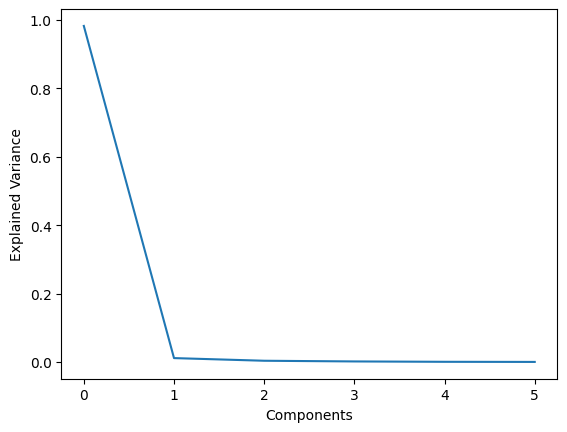

In [6]:
# Perform PCA to reduce dimensionality
pca = PCA(n_components=6)

# Fit to the pca model
pca.fit(df.T)

# Plot results
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

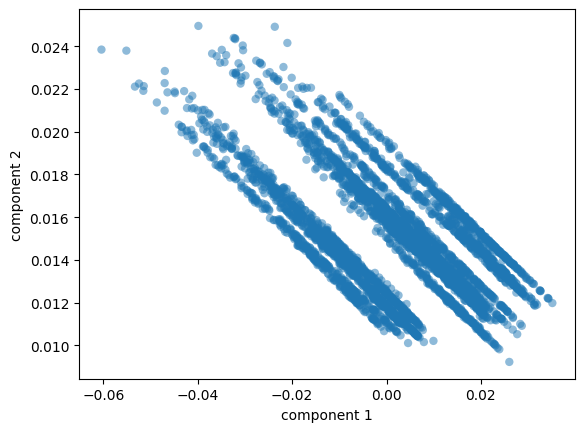

In [7]:
# Grab first two vectors of PCA to reduce data dimension
X = pca.components_[:2] 

# Visualize the new data
plt.scatter(X.T[:,1], X.T[:,0], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('autumn', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()


In [8]:
# Separate train/test sets
x_train, x_test, y_train, y_test = train_test_split(X.T, y, test_size=0.20, random_state=420)

print('training length size', len(x_train))
print('testing set size', len(x_test))

training length size 3472
testing set size 869


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

#Train the rrandom forest classifier using the training sets
rfc = RandomForestClassifier(max_depth=18,
                             min_samples_leaf= 2,
                             min_samples_split =2, 
                             n_estimators=256, 
                             random_state=0
)
rfc.fit(x_test,y_test)

# Predict the labels
ypred = rfc.predict(x_test)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Model Accuracy
print("random forest REPORT")
print(classification_report(ypred, y_test))

ypredtrain = rfc.predict(x_train)
print("test accuracy :",metrics.accuracy_score(y_train, ypredtrain))

print(confusion_matrix(ypred, y_test))
print("validation accuracy:",metrics.accuracy_score(y_test, ypred))

random forest REPORT
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       173
           1       1.00      0.90      0.94       696

    accuracy                           0.92       869
   macro avg       0.85      0.95      0.88       869
weighted avg       0.94      0.92      0.92       869

test accuracy : 0.6684907834101382
[[172   1]
 [ 72 624]]
validation accuracy: 0.9159953970080552


++++ GENERATING TREE REPRESENTATION ++++


[Text(0.405269515562249, 0.9736842105263158, '[0.01410103 0.01056257] <= 0.011\ngini = 0.409\nsamples = 557\nvalue = [249, 620]'),
 Text(0.20256024096385541, 0.9210526315789473, '[0.01606736 0.00148199] <= 0.004\ngini = 0.477\nsamples = 18\nvalue = [17, 11]'),
 Text(0.1945281124497992, 0.868421052631579, 'gini = 0.0\nsamples = 2\nvalue = [0, 3]'),
 Text(0.21059236947791166, 0.868421052631579, '[0.01410103 0.01056257] <= 0.011\ngini = 0.435\nsamples = 16\nvalue = [17, 8]'),
 Text(0.1945281124497992, 0.8157894736842105, '[0.01606736 0.00148199] <= 0.022\ngini = 0.375\nsamples = 6\nvalue = [2, 6]'),
 Text(0.18649598393574296, 0.7631578947368421, 'gini = 0.0\nsamples = 4\nvalue = [0, 5]'),
 Text(0.20256024096385541, 0.7631578947368421, 'gini = 0.444\nsamples = 2\nvalue = [2, 1]'),
 Text(0.22665662650602408, 0.8157894736842105, '[0.01410103 0.01056257] <= 0.011\ngini = 0.208\nsamples = 10\nvalue = [15, 2]'),
 Text(0.21862449799196787, 0.7631578947368421, 'gini = 0.0\nsamples = 7\nvalue = [1

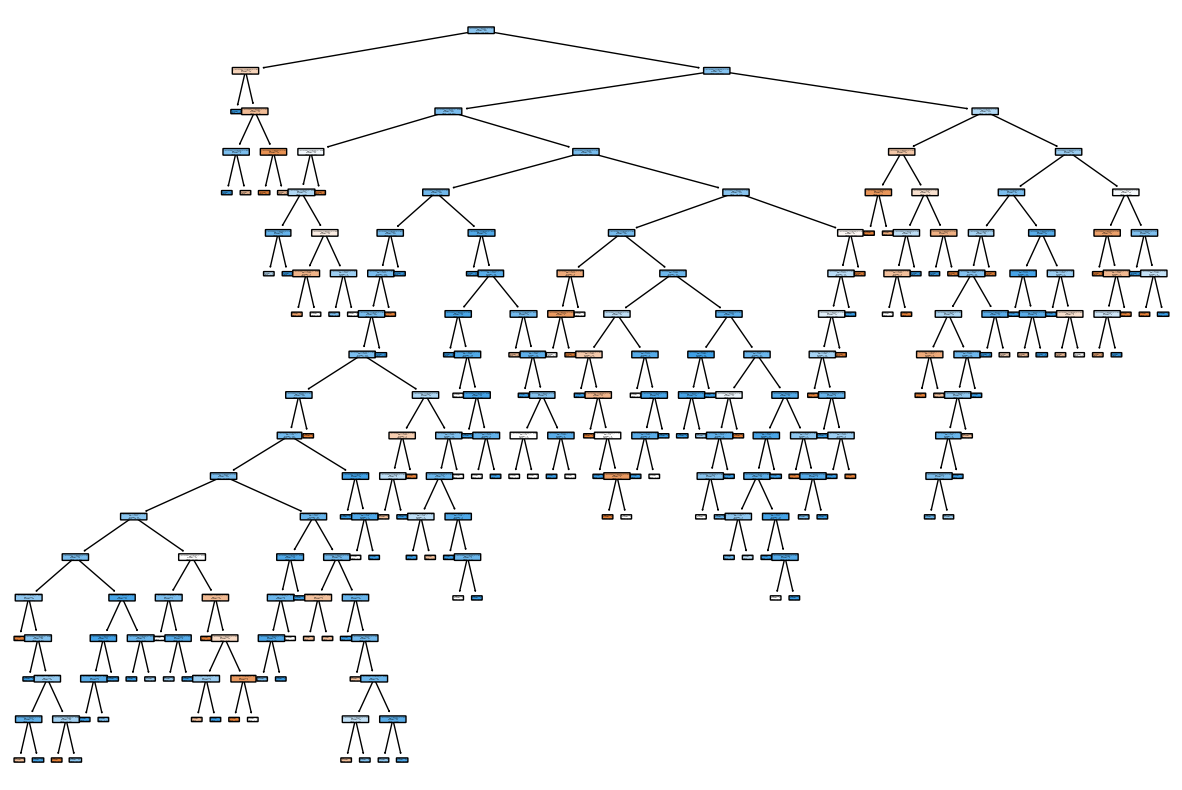

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('++++ GENERATING TREE REPRESENTATION ++++')
fig = plt.figure(figsize=(15, 10))
plot_tree(rfc.estimators_[0], 
            feature_names=[X[:,1], X[:,0]],
          filled=True, impurity=True, 
          rounded=True)